# 임베딩 내 편향성 알아보기 프로젝트

In [14]:
import konlpy
import gensim
import sklearn

import os
from konlpy.tag import Okt

import numpy as np
import seaborn as sns
from numpy import dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer



## 함수

In [5]:

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)



## 데이터 로드 및 명사 추출

In [20]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print(len(tokenized))

71156


In [6]:

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))


synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.
synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


## 워드 임베딩 모델 생성

In [21]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['사랑'])


[('첫사랑', 0.698091447353363),
 ('행복', 0.6971808671951294),
 ('진심', 0.6843549609184265),
 ('애정', 0.6826778054237366),
 ('연애', 0.6742998361587524),
 ('가슴', 0.6678144931793213),
 ('이별', 0.6669246554374695),
 ('우정', 0.6655886173248291),
 ('정해준', 0.6621353626251221),
 ('감정', 0.6606471538543701)]

## 대표 단어 선정 ( TF-IDF )

In [7]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [8]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 


In [22]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [23]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break
        
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [52]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)


(21, 42191)


In [53]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

## WEAT score 계산 및 시각화

In [54]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])


SF 가족 -0.5183739
SF 공연 -0.37253994
SF 공포(호러) -0.64376223
SF 기타 0.33085874
SF 다큐멘터리 0.60150313
SF 드라마 -0.36094397
SF 멜로로맨스 -0.7815182
SF 뮤지컬 0.33471137
SF 미스터리 -0.6541355
SF 범죄 -0.19954385
SF 사극 -0.8322306
SF 서부극(웨스턴) -0.42593178
SF 성인물(에로) -0.5584645
SF 스릴러 -0.49423736
SF 애니메이션 0.36196557
SF 액션 -0.43785083
SF 어드벤처 -0.7764774
SF 전쟁 0.19160509
SF 코미디 -0.43565217
SF 판타지 -0.16196801
가족 공연 0.17846484
가족 공포(호러) -0.13973661
가족 기타 0.72759557
가족 다큐멘터리 0.83440965
가족 드라마 0.2306684
가족 멜로로맨스 -0.6292212
가족 뮤지컬 0.6880117
가족 미스터리 -0.28133413
가족 범죄 0.24894845
가족 사극 -0.08462949
가족 서부극(웨스턴) 0.4029136
가족 성인물(에로) -0.31522632
가족 스릴러 -0.113192126
가족 애니메이션 0.85126144
가족 액션 0.124288775
가족 어드벤처 -0.017835164
가족 전쟁 0.6194979
가족 코미디 0.19872223
가족 판타지 0.4558609
공연 공포(호러) -0.22330149
공연 기타 0.93007183
공연 다큐멘터리 0.9427484
공연 드라마 0.027188398
공연 멜로로맨스 -0.695166
공연 뮤지컬 0.8941069
공연 미스터리 -0.32666346
공연 범죄 0.1091487
공연 사극 -0.36759198
공연 서부극(웨스턴) 0.04699246
공연 성인물(에로) -0.4737771
공연 스릴러 -0.19107969
공연 애니메이션 0.9173579
공연 액션 -0

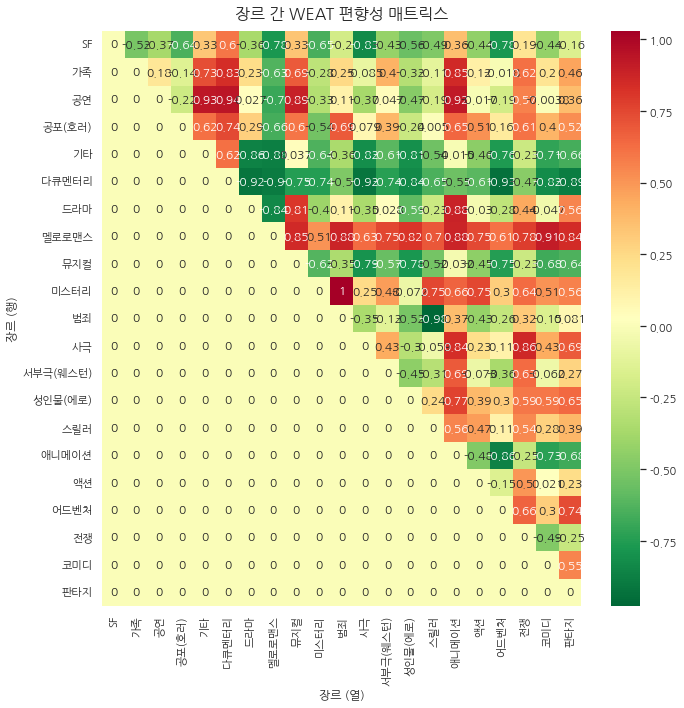

In [55]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,10))

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
# 제목 및 축 레이블 추가
ax.set_title("장르 간 WEAT 편향성 매트릭스", fontsize=16, pad=12)
ax.set_xlabel("장르 (열)", fontsize=12)
ax.set_ylabel("장르 (행)", fontsize=12)

plt.tight_layout()
plt.show()

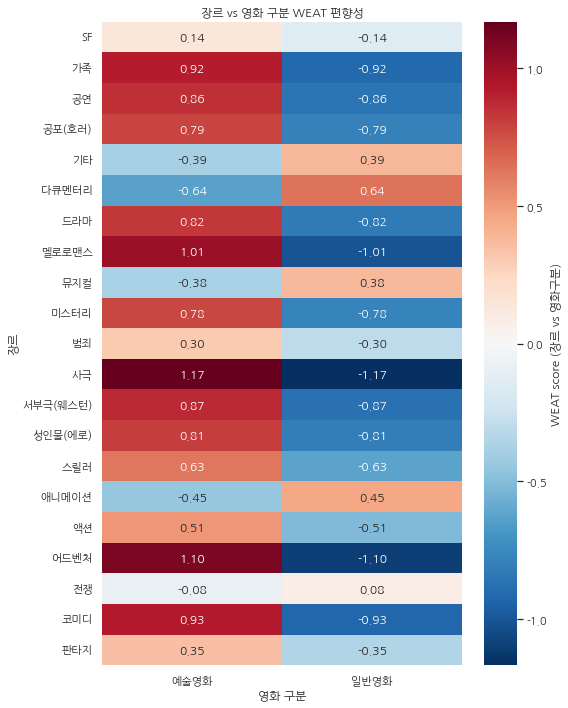

In [56]:
film_types = ["예술영화", "일반영화"]
targets = {
    "예술영화": target_art,  # 앞에서 만든 예술영화 대표 단어 리스트
    "일반영화": target_gen   # 앞에서 만든 일반영화 대표 단어 리스트
}

# 1) "장르 vs 영화 구분" 매트릭스 초기화
mat2 = np.zeros((len(genre_name), len(film_types)))

# 2) attribute_B(비장르) 미리 준비: 각 장르를 제외한 나머지 장르 단어 합집합
all_attrs = [w for attr in attributes for w in attr]
genre_attrs_except = []
for i in range(len(genre_name)):
    # 이 장르(attributes[i])를 제외한 모든 단어
    others = [w for w in all_attrs if w not in attributes[i]]
    genre_attrs_except.append(others)

# 3) WEAT score 계산: 
#    X/Y = 예술 vs 일반 target, A = 이 장르 단어, B = 비장르 단어
for i, g in enumerate(genre_name):
    A = np.array([model.wv[w] for w in attributes[i]])
    B = np.array([model.wv[w] for w in genre_attrs_except[i]])
    for j, ft in enumerate(film_types):
        X = np.array([model.wv[w] for w in targets[ft]])
        # 다른 영화 구분을 Y로
        other = film_types[1-j]
        Y = np.array([model.wv[w] for w in targets[other]])
        mat2[i, j] = weat_score(X, Y, A, B)

# 4) 히트맵 그리기
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 10))
ax = sns.heatmap(
    mat2,
    xticklabels=film_types,
    yticklabels=genre_name,
    center=0,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "WEAT score (장르 vs 영화구분)"}
)
ax.set_title("장르 vs 영화 구분 WEAT 편향성")
ax.set_xlabel("영화 구분")
ax.set_ylabel("장르")
plt.tight_layout()
plt.show()

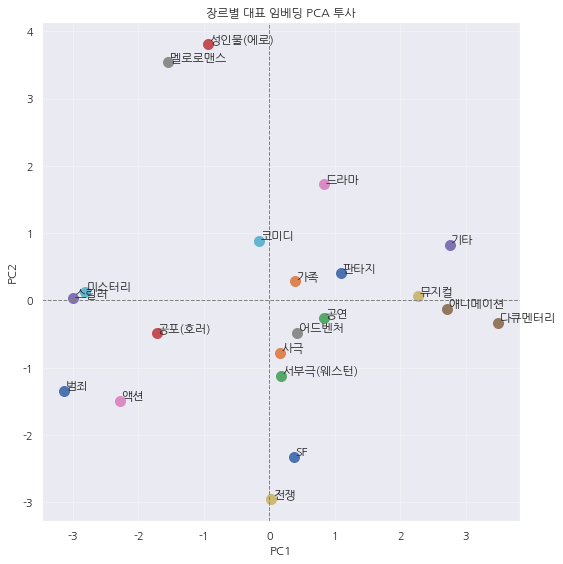

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1) 장르별 대표 임베딩(centroid) 계산
genre_centroids = []
for attr in attributes:
    vecs = np.array([model.wv[w] for w in attr])
    centroid = vecs.mean(axis=0)
    genre_centroids.append(centroid)
genre_centroids = np.vstack(genre_centroids)  # shape (n_genres, dim)

# 2) PCA로 2차원 투사
pca = PCA(n_components=2, random_state=0)
coords = pca.fit_transform(genre_centroids)   # shape (n_genres, 2)

# 3) 산점도 그리기
plt.figure(figsize=(8,8))
for i, (x, y) in enumerate(coords):
    plt.scatter(x, y, s=100)
    plt.text(x+0.02, y+0.02, genre_name[i], fontsize=12)

plt.title("장르별 대표 임베딩 PCA 투사")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 추가 실험 ( 장르 대표 단어 중복 제거 )

In [58]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)


(21, 42191)


In [59]:
from collections import Counter

# 1) 중복 허용 최대 횟수 결정 (장르 수에 따라)
num_genres = len(genre_name)
# 대략 장르 수의 1/10 정도를 허용치로 잡아보았습니다.
max_dup = max(1, num_genres // 10)  # 21//10 = 2
half_limit = num_genres / 2            # 절반 이상 등장하면 아예 제외


# 2) TF-IDF 상위 후보(w) 생성 (기존 그대로)
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

# 3) TF-IDF 후보 단계에서의 등장 횟수 세기
initial_count = Counter()
for i in range(len(w)):
    top100 = [vectorizer.get_feature_names_out()[idx] for idx, _ in w[i][:100]]
    initial_count.update(top100)

# 4) 전역 허용 카운터 초기화
global_count = Counter()

# 5) 각 장르별 attr 리스트 생성 (최대 n)
attributes = []
n = 15
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while len(attr) < n and j < len(w[i]):
        word = vectorizer.get_feature_names_out()[w[i][j][0]]
        j += 1

        # ————————————————
        # 1) 모델에 있는 단어
        # 2) 아직 이 장르 리스트에 없고
        # 3) 전역 중복 < max_dup
        # ————————————————

        if (word in model.wv
            and word not in attr
            and global_count[word] < max_dup
            and initial_count[word] < half_limit):
            
            attr.append(word)
            global_count[word] += 1
            print(word, end=', ')
    attributes.append(attr)
    print()

SF: 지구, 인류, 인간, 미래, 우주, 로봇, 박사, 우주선, 외계, 존재, 행성, 정체, 전쟁, 공격, 실험, 
가족: 아빠, 아주르, 국제, 낙타, 할머니, 씨제이, 동구, 학교, 소년, 슈이트, 어머니, 마갈, 소녀, 미아, 펠리칸, 
공연: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 
공포(호러): 공포, 죽음, 악령, 좀비, 소녀, 살인, 정체, 저주, 살해, 의문, 점점, 사고, 명의, 이후, 일행, 
기타: 국제, 서울, 단편, 뉴미디어, 페스티벌, 독립, 작품, 아시아나, 우리, 연출, 이미지, 부산, 소년, 상영작, 지하철, 
다큐멘터리: 다큐, 다큐멘터리, 감독, 서울, 우리, 여성, 한국, 작품, 환경, 사회, 노동자, 기록, 역사, 음악, 미국, 
드라마: 단편, 남편, 감독, 관계, 때문, 부문, 연출, 어머니, 학교, 생활, 결혼, 독립, 인생, 간다, 점점, 
멜로로맨스: 남편, 섹스, 결혼, 관계, 부부, 회사, 생활, 유혹, 연애, 애인, 때문, 새엄마, 불륜, 남자친구, 유부녀, 
뮤지컬: 뮤지컬, 에스메랄다, 음악, 충무로, 모차르트, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 샤오캉, 
미스터리: 사고, 진실, 죽음, 살인, 민혁, 의문, 미스터리, 형사, 경찰, 현우, 발생, 방독면, 범인, 살해, 충격, 
범죄: 경찰, 범죄, 조직, 마약, 형사, 수사, 한길수, 범인, 계획, 은행, 작전, 동료, 보스, 미국, 마피아, 
사극: 조선, 신기전, 아가멤논, 황제, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 채선, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 랜던, 
성인물(에로): 마사지, 섹스, 정사, 유부녀, 에피소드, 그린, 자위, 회사, 불륜, 욕구, 유이, 부부, 유혹, 욕구불만, 

In [60]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])


SF 가족 -0.6568518
SF 공연 -0.13428755
SF 공포(호러) -0.74067134
SF 기타 0.40929356
SF 다큐멘터리 0.453256
SF 드라마 -0.2995843
SF 멜로로맨스 -0.6493712
SF 뮤지컬 0.08489764
SF 미스터리 -0.54164946
SF 범죄 -0.14351648
SF 사극 -0.48306745
SF 서부극(웨스턴) -0.5536855
SF 성인물(에로) -0.51668227
SF 스릴러 -0.56493783
SF 애니메이션 0.24999465
SF 액션 -0.3787751
SF 어드벤처 -0.94971085
SF 전쟁 0.119235076
SF 코미디 -0.8477815
SF 판타지 -0.73378885
가족 공연 0.5161687
가족 공포(호러) -0.071229294
가족 기타 0.9279525
가족 다큐멘터리 0.8661199
가족 드라마 0.624967
가족 멜로로맨스 -0.3762573
가족 뮤지컬 0.74538153
가족 미스터리 0.06255236
가족 범죄 0.47086954
가족 사극 0.47311276
가족 서부극(웨스턴) 0.41715875
가족 성인물(에로) -0.15984432
가족 스릴러 0.16252075
가족 애니메이션 0.8907684
가족 액션 0.28917348
가족 어드벤처 0.019969424
가족 전쟁 0.71680903
가족 코미디 -0.5795079
가족 판타지 0.36871135
공연 공포(호러) -0.36170107
공연 기타 0.95685536
공연 다큐멘터리 0.71592355
공연 드라마 -0.2040013
공연 멜로로맨스 -0.5802944
공연 뮤지컬 0.78711194
공연 미스터리 -0.2604694
공연 범죄 0.012320257
공연 사극 -0.27294448
공연 서부극(웨스턴) -0.3245886
공연 성인물(에로) -0.49104282
공연 스릴러 -0.23961093
공연 애니메이션 0.8639858
공연 액션 -0.12

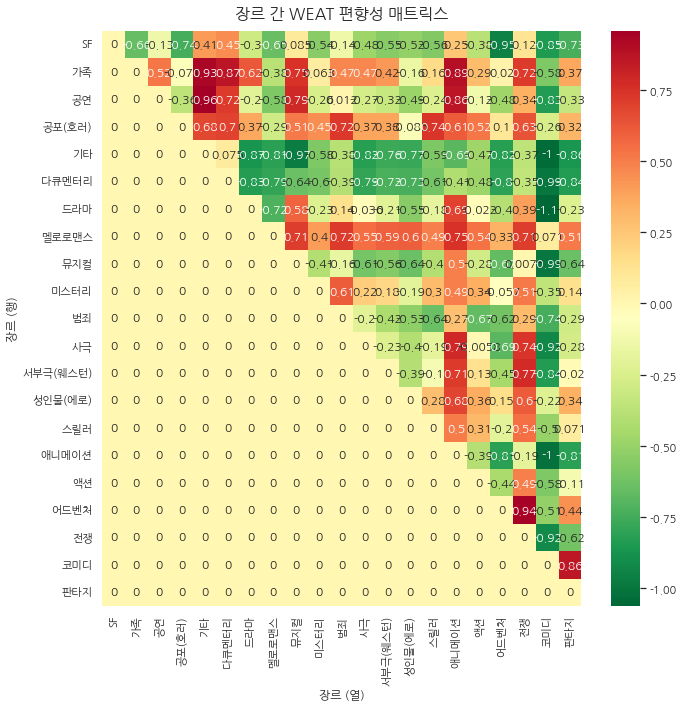

In [61]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,10))

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
# 제목 및 축 레이블 추가
ax.set_title("장르 간 WEAT 편향성 매트릭스", fontsize=16, pad=12)
ax.set_xlabel("장르 (열)", fontsize=12)
ax.set_ylabel("장르 (행)", fontsize=12)

plt.tight_layout()
plt.show()

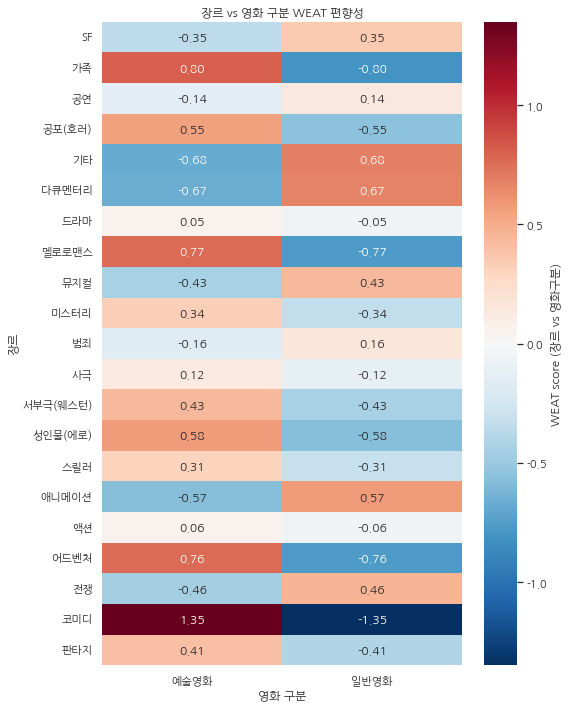

In [62]:
film_types = ["예술영화", "일반영화"]
targets = {
    "예술영화": target_art,  # 앞에서 만든 예술영화 대표 단어 리스트
    "일반영화": target_gen   # 앞에서 만든 일반영화 대표 단어 리스트
}

# 1) "장르 vs 영화 구분" 매트릭스 초기화
mat2 = np.zeros((len(genre_name), len(film_types)))

# 2) attribute_B(비장르) 미리 준비: 각 장르를 제외한 나머지 장르 단어 합집합
all_attrs = [w for attr in attributes for w in attr]
genre_attrs_except = []
for i in range(len(genre_name)):
    # 이 장르(attributes[i])를 제외한 모든 단어
    others = [w for w in all_attrs if w not in attributes[i]]
    genre_attrs_except.append(others)

# 3) WEAT score 계산: 
#    X/Y = 예술 vs 일반 target, A = 이 장르 단어, B = 비장르 단어
for i, g in enumerate(genre_name):
    A = np.array([model.wv[w] for w in attributes[i]])
    B = np.array([model.wv[w] for w in genre_attrs_except[i]])
    for j, ft in enumerate(film_types):
        X = np.array([model.wv[w] for w in targets[ft]])
        # 다른 영화 구분을 Y로
        other = film_types[1-j]
        Y = np.array([model.wv[w] for w in targets[other]])
        mat2[i, j] = weat_score(X, Y, A, B)

# 4) 히트맵 그리기
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 10))
ax = sns.heatmap(
    mat2,
    xticklabels=film_types,
    yticklabels=genre_name,
    center=0,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "WEAT score (장르 vs 영화구분)"}
)
ax.set_title("장르 vs 영화 구분 WEAT 편향성")
ax.set_xlabel("영화 구분")
ax.set_ylabel("장르")
plt.tight_layout()
plt.show()

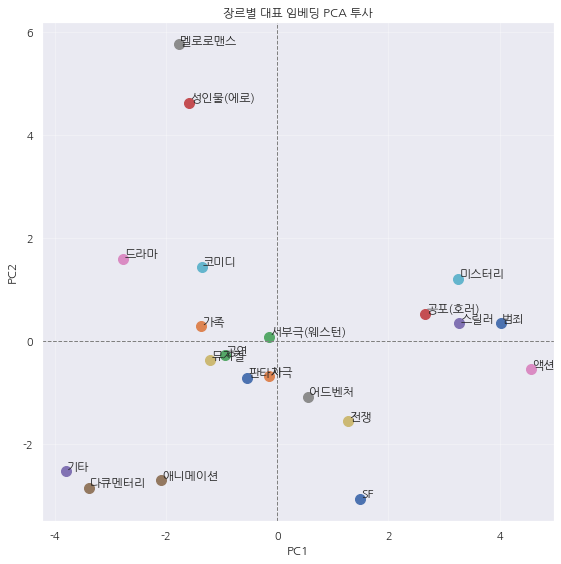

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1) 장르별 대표 임베딩(centroid) 계산
genre_centroids = []
for attr in attributes:
    vecs = np.array([model.wv[w] for w in attr])
    centroid = vecs.mean(axis=0)
    genre_centroids.append(centroid)
genre_centroids = np.vstack(genre_centroids)  # shape (n_genres, dim)

# 2) PCA로 2차원 투사
pca = PCA(n_components=2, random_state=0)
coords = pca.fit_transform(genre_centroids)   # shape (n_genres, 2)

# 3) 산점도 그리기
plt.figure(figsize=(8,8))
for i, (x, y) in enumerate(coords):
    plt.scatter(x, y, s=100)
    plt.text(x+0.02, y+0.02, genre_name[i], fontsize=12)

plt.title("장르별 대표 임베딩 PCA 투사")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.axvline(0, color='grey', lw=1, linestyle='--')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 결과 분석

## 회고

